In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/TX/TX_prison_revocations_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
# test_sim.simulate_baseline('probation', 'parole')

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 600 results
transitions_data returned 11 results
total_population_data returned 360 results


,x
parole,0.880870
prison_parole_revocations,0.869129
probation,0.814118


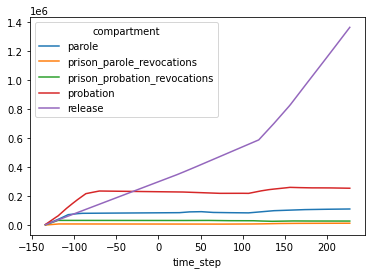

In [4]:
# need to have run baseline for this to work: checking the scale factors are decently close to 1 and population projections look reasonable
test_sim.pop_simulations['baseline'].population_projections.groupby(['time_step', 'compartment']).total_population.sum().unstack().plot()
test_sim.pop_simulations['baseline'].gen_scale_factors_df()

In [6]:
# need to have run baseline: looking at the transition tables to get a sense for what I need to change
test_sim.pop_simulations['baseline'].sub_simulations['x'].simulation_compartments['parole'].transition_tables.transition_dfs

{'before':     prison_parole_revocations   release  remaining
 1                    0.000000  0.000000   1.000000
 2                    0.000000  0.000000   1.000000
 3                    0.000000  0.000000   1.000000
 4                    0.000000  0.000000   1.000000
 5                    0.000000  0.000000   1.000000
 6                    0.000000  0.000000   1.000000
 7                    0.000000  0.000000   1.000000
 8                    0.000000  0.000000   1.000000
 9                    0.000000  0.000000   1.000000
 10                   0.000000  0.000000   1.000000
 11                   0.000000  0.000000   1.000000
 12                   0.045000  0.000000   0.955000
 13                   0.000000  0.000000   1.000000
 14                   0.000000  0.000000   1.000000
 15                   0.000000  0.000000   1.000000
 16                   0.000000  0.000000   1.000000
 17                   0.000000  0.000000   1.000000
 18                   0.000000  0.000000   1.000000
 1

In [8]:
#reminding myself what the sub-groups are, in this case there's just one monolithic group
test_sim.pop_simulations['baseline'].sub_group_ids_dict

{'x': {'placeholder_axis': 'x'}}

initialization time:  16.300544023513794
simulation_time:  11.354208946228027
initialization time:  14.830559015274048
simulation_time:  10.236922025680542


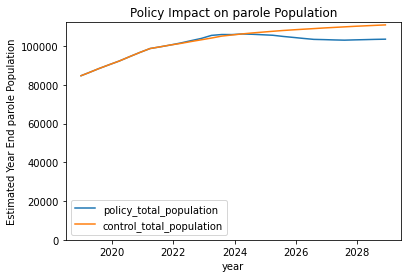

In [6]:
# Policy Option Methods
revocation_outflows = {
    'parole': 'prison_parole_revocations',
    'probation': 'prison_probation_revocations',
}
REVOCATION_REDUCTION = 0.4

def incentivize_completions(reduction, compartment, retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':[revocation_outflows[compartment]],
                       'affected_fraction': [reduction],
                       'new_outflow': [None]
                   }),
                   retroactive=retroactive)


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=incentivize_completions(REVOCATION_REDUCTION, compartment),
                spark_compartment=compartment,
                sub_population={'placeholder_axis': 'x'},
                apply_retroactive=False)
    for compartment in revocation_outflows
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'parole')

In [5]:
#peeking at the transition tables to make sure they're transformed the way I expect them to be
test_sim.pop_simulations['policy'].sub_simulations['x'].simulation_compartments['probation'].transition_tables.transition_dfs

{'before':     prison_probation_revocations  release  remaining
 1                       0.000000      0.0   1.000000
 2                       0.000000      0.0   1.000000
 3                       0.000000      0.0   1.000000
 4                       0.000000      0.0   1.000000
 5                       0.000000      0.0   1.000000
 6                       0.000000      0.0   1.000000
 7                       0.000000      0.0   1.000000
 8                       0.000000      0.0   1.000000
 9                       0.000000      0.0   1.000000
 10                      0.000000      0.0   1.000000
 11                      0.000000      0.0   1.000000
 12                      0.100000      0.0   0.900000
 13                      0.000000      0.0   1.000000
 14                      0.000000      0.0   1.000000
 15                      0.000000      0.0   1.000000
 16                      0.000000      0.0   1.000000
 17                      0.000000      0.0   1.000000
 18               

In [7]:
simulation_tag = 'TX_PO_incentives_40%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [9]:
test_sim.output_data['cost_avoidance']

,parole,release,prison_parole_revocations,prison_probation_revocations,probation
year,,,,,
2019.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000
2019.083333,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000
2019.166667,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000
2019.250000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000
2019.333333,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...
2028.583333,747275.057824,-0.0,9.424635e+06,2.117043e+07,-209661.299739
2028.666667,771662.477646,-0.0,9.601435e+06,2.154937e+07,-182588.479354
2028.750000,796166.364966,-0.0,9.778587e+06,2.192879e+07,-154988.891051


In [8]:
test_sim.pop_simulations['control'].sub_simulations['x'].simulation_compartments['prison_parole_revocations'].transition_tables.transition_dfs

{'before':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.0        1.0
 8      0.0        1.0
 9      0.0        1.0
 10     0.0        1.0
 11     0.0        1.0
 12     0.0        1.0
 13     0.0        1.0
 14     0.0        1.0
 15     0.0        1.0
 16     1.0        0.0,
 'transitory':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.0        1.0
 8      0.0        1.0
 9      0.0        1.0
 10     0.0        1.0
 11     0.0        1.0
 12     0.0        1.0
 13     0.0        1.0
 14     0.0        1.0
 15     0.0        1.0
 16     1.0        0.0,
 'after_retroactive':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.